In [1]:
from comet_ml import Experiment

import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import copy
import hdbscan
import astropy
import sys
import warnings 

from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from astropy.coordinates import Distance
from astropy import units as u
from astropy.cosmology import WMAP7
from astropy.io import fits

from collections import Counter
from pandas.api.types import is_numeric_dtype

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from xgboost import XGBRegressor

In [2]:
# insert at 1, 0 is the script path (or '' in REPL)
PATH = '/datadrive/azarodnyuk/GALAXY/'
sys.path.insert(1, PATH)

In [3]:
# cd ../

In [4]:
y = pd.read_csv(sys.path[1]+'iGrID_rcsed_8_clean.csv', index_col='Unnamed: 0')
fltr = pd.notna(y.iGrID)

In [5]:
# Use the code below to download the original dataset

# hdul = fits.open('http://gal-03.sai.msu.ru/~vtoptun/photometry/rcsed_v2_8.fits', memmap=astropy.io.fits.Conf.use_memmap.defaultvalue, lazy_load_hdus=True)

In [6]:
# hdul = fits.open(sys.path[1]+'rcsed_v2_8.fits', memmap=astropy.io.fits.Conf.use_memmap.defaultvalue, lazy_load_hdus=True)

In [7]:
# cols = hdul[1].columns

In [8]:
# data = hdul[1].data

In [9]:
# hdul.close()
# del hdul

In [10]:
# DATA = pd.DataFrame(np.array(data).byteswap().newbyteorder())
# del data

In [12]:
DATA = pd.read_csv(PATH+'rcsed_v2_8.csv')

In [13]:
DATA.shape

(4109726, 480)

In [14]:
type_stats = {}
for c in DATA.columns:
    t = DATA[c].dtype
    if t in type_stats:
        type_stats[DATA[c].dtype] += 1
    else:
        type_stats[DATA[c].dtype] = 1

print(type_stats)

{dtype('int64'): 24, dtype('float64'): 447, dtype('O'): 9}


In [15]:
for c in DATA.columns:
    t = DATA[c].dtype
    if t == '<i8':
        print(c)

Unnamed: 0
ind
bestObjID_sdss
bossSpecObjID_sdss
mjd_sdss
plate_sdss
fiberID_sdss
q_z_2df
quality_6df
specid_6df
recno_uzc
obsid_lamost
lmjd_lamost
mjd_lamost
spid_lamost
fiberid_lamost
f_z_lega_c
f_spec_lega_c
OBJNO_deep2
OBJNO_deep3
Q_wigglez
NQ_gama
qual_2dFLenS
target_2dFLenS


In [16]:
DATA.drop(['ind', 'bestObjID_sdss'], inplace=True, axis=1)
DATA = DATA.select_dtypes(include='number')

In [17]:
DATA.shape

(4109726, 469)

In [18]:
type_stats = {}
for c in DATA.columns:
    t = DATA[c].dtype
    if t in type_stats:
        type_stats[DATA[c].dtype] += 1
    else:
        type_stats[DATA[c].dtype] = 1

print(type_stats)

{dtype('int64'): 22, dtype('float64'): 447}


In [19]:
# print(f'{0.19692286055080072: <20} | {0.19692286055080072: >20.5%} | {0.19692286055080072: >20.5%}')
# print(f'{"":_<67}')

In [20]:
len("percents of nan in filtered")

27

In [21]:
print(f"{'column name': <20} | {'percents of nan in full data': >20} | {'percents of nan in filtered': >20}")
print(f'{"":_<83}')
for c in DATA.columns:
    print(f'{c: <20} | {DATA[c].isna().sum()/DATA.shape[0]: >28.5%} | {DATA[fltr][c].isna().sum()/DATA[fltr].shape[0]: >27.5%}')
#     print(c, ' | ', DATA[c].isna().sum()/DATA.shape[0] , '% |', DATA[fltr][c].isna().sum()/DATA[fltr].shape[0], '%')

column name          | percents of nan in full data | percents of nan in filtered
___________________________________________________________________________________
Unnamed: 0           |                     0.00000% |                    0.00000%
ra                   |                     0.00000% |                    0.00000%
dec                  |                     0.00000% |                    0.00000%
z_sdss               |                    23.23347% |                    0.00000%
zErr_sdss            |                    23.17658% |                    0.00000%
specObjID_sdss       |                    23.17658% |                    0.00000%
bossSpecObjID_sdss   |                     0.00000% |                    0.00000%
mjd_sdss             |                     0.00000% |                    0.00000%
plate_sdss           |                     0.00000% |                    0.00000%
fiberID_sdss         |                     0.00000% |                    0.00000%
z_2df         

In [22]:
for c in DATA.columns:
    print(c, DATA[c].value_counts().head(5))
    print(DATA[c].min(), DATA[c].median(), DATA[c].max())
    print()

Unnamed: 0 4094       1
2748523    1
3047557    1
3059843    1
3055745    1
Name: Unnamed: 0, dtype: int64
0 2054862.5 4109725

ra 202.288329    11
202.454996    11
308.501958    11
308.551971    10
309.135304    10
Name: ra, dtype: int64
1.91320889939561e-05 176.50698500000001 359.99994

dec 60.169022    23
46.708668    21
46.725334    21
60.185688    19
60.235687    17
Name: dec, dtype: int64
-87.1364722 17.020318500000002 89.09305572509766

z_sdss 0.004153    334
0.004153    300
7.011245    263
0.003460     20
1.002166     19
Name: z_sdss, dtype: int64
0.001600324 0.48972605 7.0519300000000005

zErr_sdss -1.0    5738
 0.0     847
-4.0     743
-6.0     223
-5.0     132
Name: zErr_sdss, dtype: int64
-6.0 0.00011573495 6753.215999999999

specObjID_sdss 5.821645e+17    4
3.749442e+17    3
3.412167e+17    3
5.810350e+17    3
3.284324e+18    3
Name: specObjID_sdss, dtype: int64
2.994896774449336e+17 5.355974808608985e+18 1.3177803682144866e+19

bossSpecObjID_sdss  0             982551
-21

In [23]:
DATA.replace([-2147483648, -9223372036854775808,-32768,255, -999999488.0,
 99.0,
 -99.0,
 9999.0,
 -999.0,
 float('inf'),
 -9999.0], np.nan, inplace=True)

In [24]:
for_del = []
print(f"{'column name': <20} | {'percents of nan in full data': >20} | {'percents of nan in filtered': >20}")
for c in DATA.columns:
#     print(c, ' | ', DATA[c].isna().sum()/DATA.shape[0] , '% |', DATA[fltr][c].isna().sum()/DATA[fltr].shape[0], '%')
    print(f'{c: <20} | {DATA[c].isna().sum()/DATA.shape[0]: >28.5%} | {DATA[fltr][c].isna().sum()/DATA[fltr].shape[0]: >27.5%}')
    if (DATA[c].isna().sum()/DATA.shape[0] > 0.5):
        for_del.append(c)

column name          | percents of nan in full data | percents of nan in filtered
Unnamed: 0           |                     0.00002% |                    0.00000%
ra                   |                     0.00000% |                    0.00000%
dec                  |                     0.00000% |                    0.00000%
z_sdss               |                    23.23347% |                    0.00000%
zErr_sdss            |                    23.17658% |                    0.00000%
specObjID_sdss       |                    23.17658% |                    0.00000%
bossSpecObjID_sdss   |                    23.17661% |                    0.00000%
mjd_sdss             |                    23.17658% |                    0.00000%
plate_sdss           |                    23.17658% |                    0.00000%
fiberID_sdss         |                    23.27591% |                    0.15737%
z_2df                |                    94.63619% |                   95.94773%
q_z_2df         

In [25]:
print(len(for_del))

380


In [26]:
DATA.drop(for_del, axis=1, inplace=True)

In [27]:
DATA.shape

(4109726, 89)

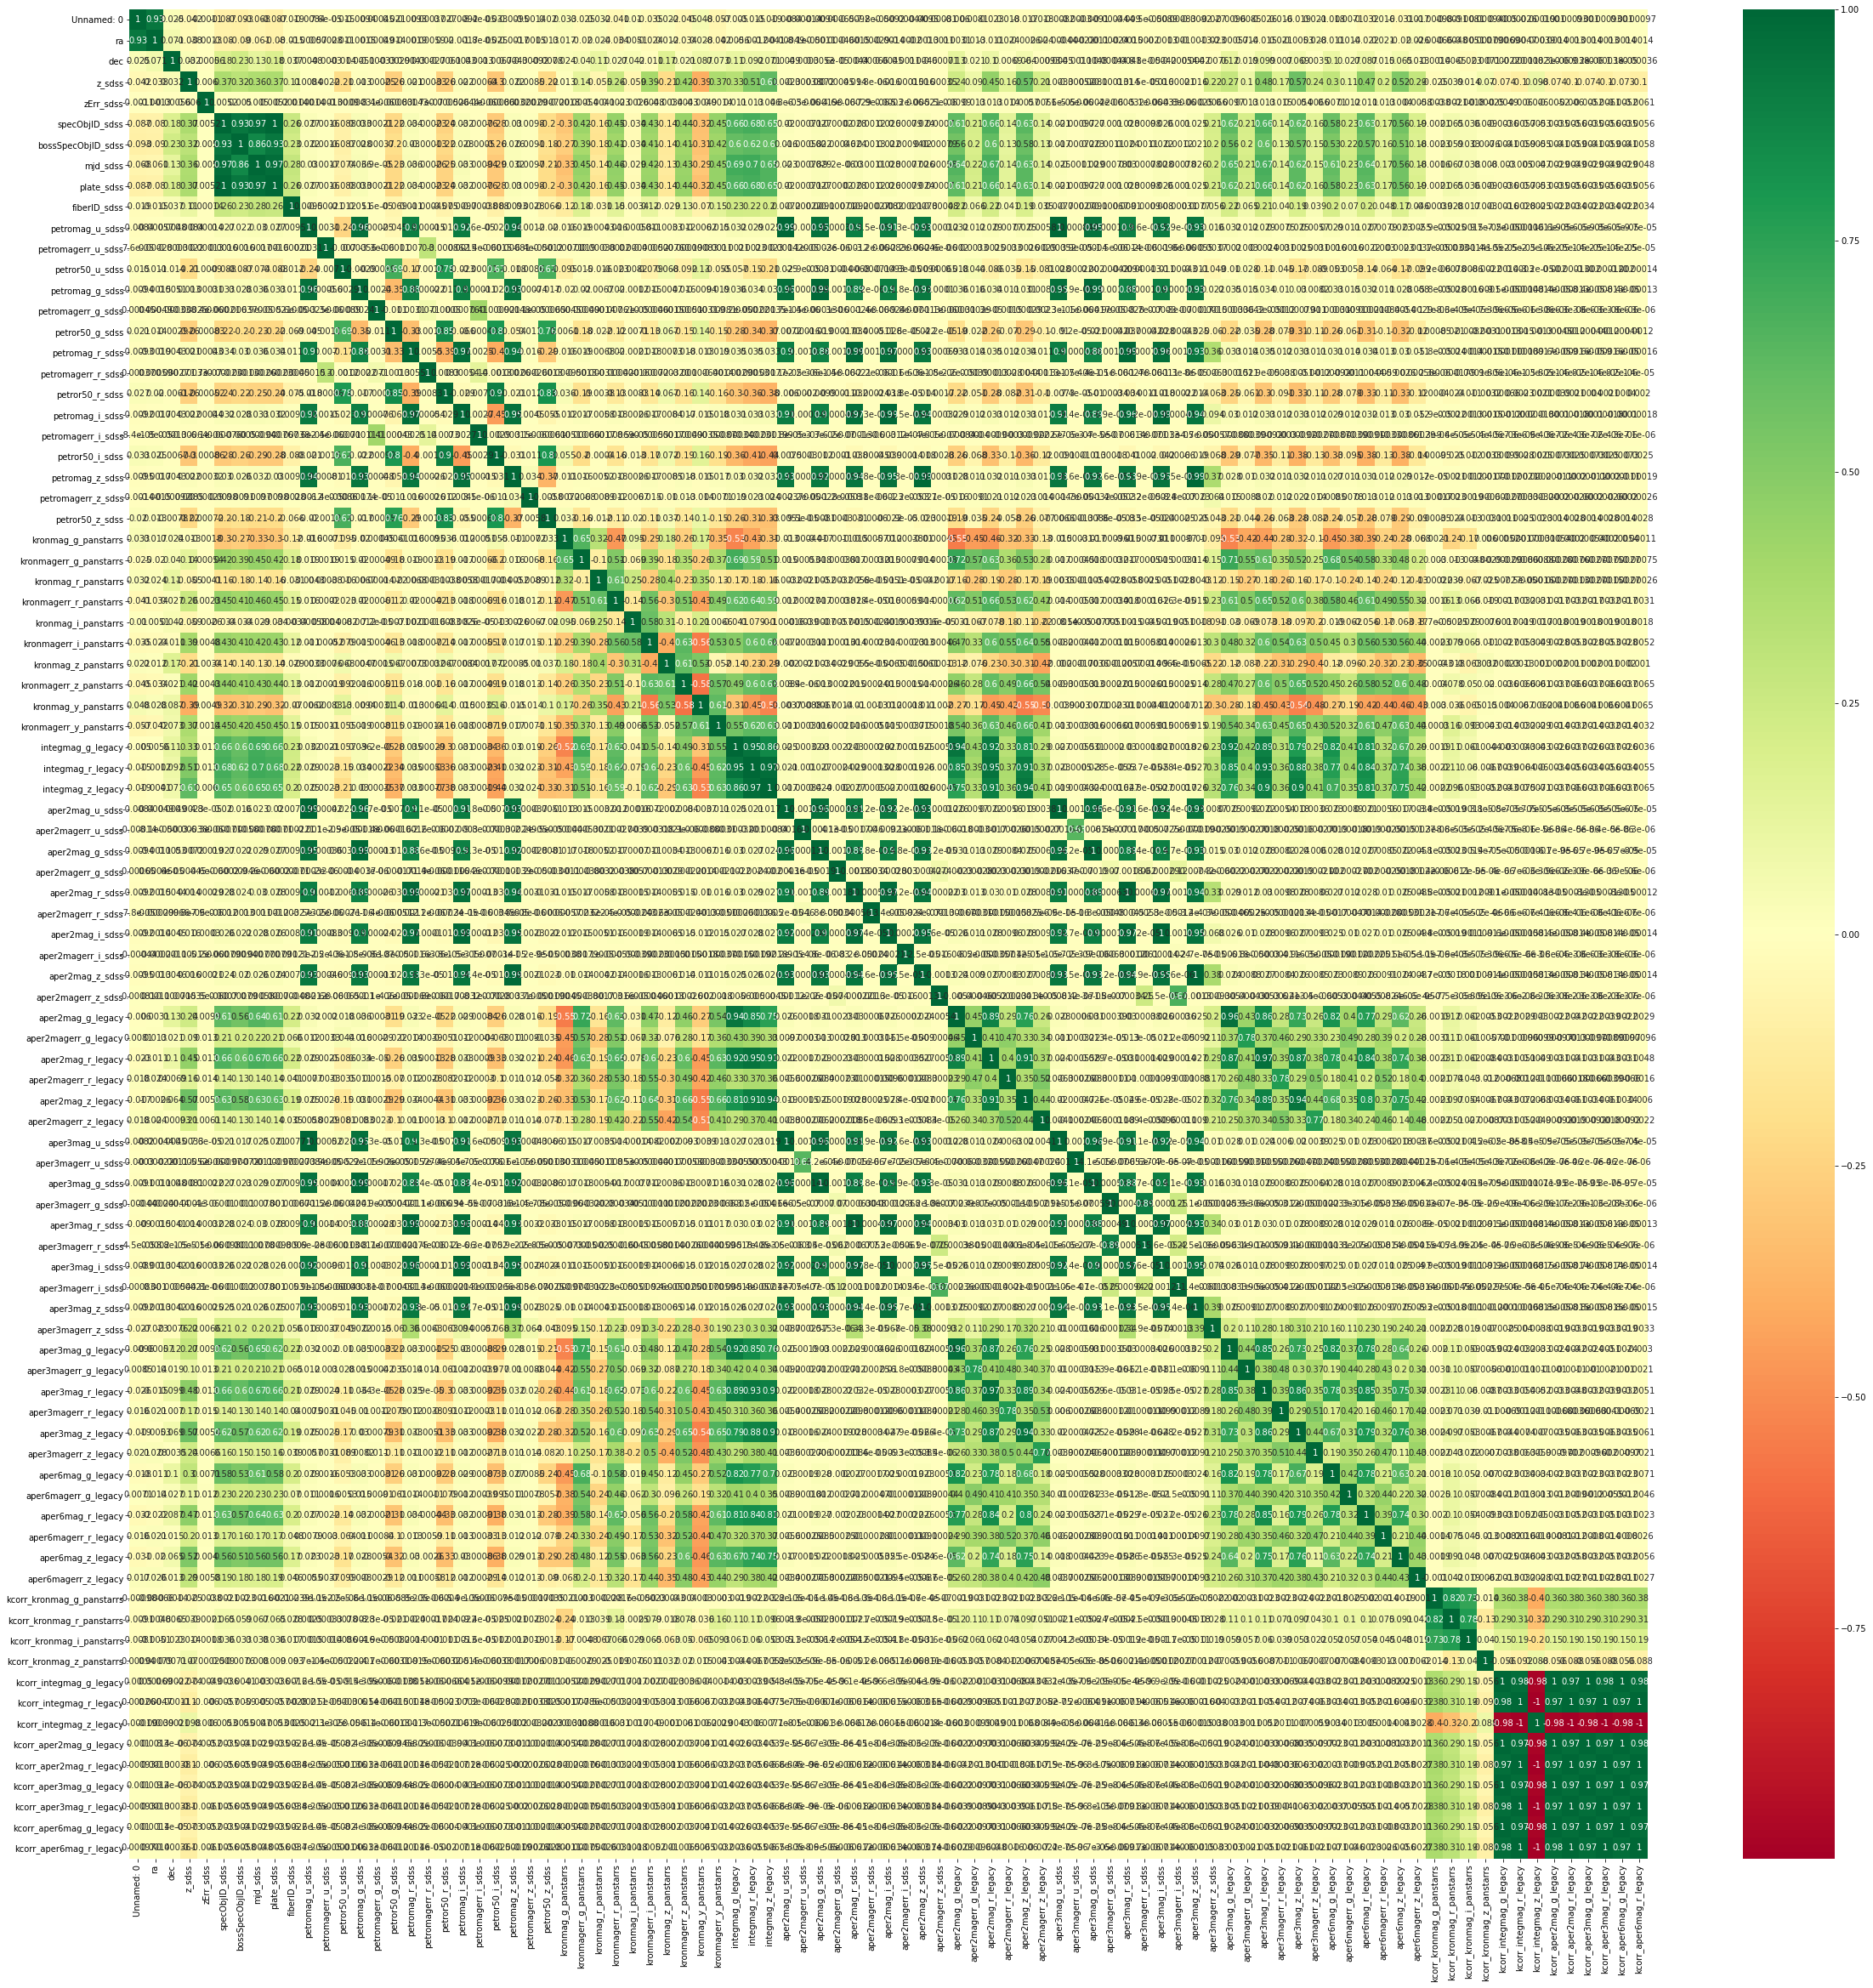

In [28]:
corrmat = DATA.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,40))
g=sns.heatmap(DATA[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig('V8corr.png')
del corrmat, top_corr_features, g

In [29]:
corrmat = abs(DATA.corr())

In [30]:
corrmat_col = corrmat.columns

In [31]:
del_list = []
for i in range(len(corrmat)-1):
    j = i+1
    while j<len(corrmat):
        if corrmat.loc[corrmat_col[i], corrmat_col[j]] > 0.95:
            del_list.append(corrmat_col[j])
            print(corrmat_col[i],'&',corrmat_col[j],'=',corrmat.loc[corrmat_col[i], corrmat_col[j]])
        j+=1

specObjID_sdss & mjd_sdss = 0.9692944900216606
specObjID_sdss & plate_sdss = 0.999999999643679
mjd_sdss & plate_sdss = 0.9692938323030836
petromag_u_sdss & petromag_g_sdss = 0.9591230485448518
petromag_u_sdss & aper2mag_u_sdss = 0.9948941742425509
petromag_u_sdss & aper2mag_g_sdss = 0.9545895614083739
petromag_u_sdss & aper3mag_u_sdss = 0.9951964459529893
petromag_u_sdss & aper3mag_g_sdss = 0.9507580704245333
petromag_g_sdss & aper2mag_u_sdss = 0.9589577338209618
petromag_g_sdss & aper2mag_g_sdss = 0.9905427280291669
petromag_g_sdss & aper3mag_u_sdss = 0.9547855391576895
petromag_g_sdss & aper3mag_g_sdss = 0.9911761444492136
petromag_r_sdss & petromag_i_sdss = 0.9701291247229648
petromag_r_sdss & aper2mag_r_sdss = 0.9910959071001398
petromag_r_sdss & aper2mag_i_sdss = 0.9658702161636962
petromag_r_sdss & aper3mag_r_sdss = 0.9915574913850395
petromag_r_sdss & aper3mag_i_sdss = 0.9624421503394209
petromag_i_sdss & petromag_z_sdss = 0.9542186150466747
petromag_i_sdss & aper2mag_r_sdss = 0

In [32]:
# len(pd.Series(del_list).unique())

In [33]:
# DATA

In [34]:
# DATA.drop(columns=pd.Series(del_list).unique(), inplace=True)

In [35]:
DATA.shape

(4109726, 89)

In [36]:
# #Correlation with output variable
# cor_target = abs(corrmat)
# #Selecting highly correlated features
# relevant_features = cor_target[cor_target>0.5]
# relevant_features


In [37]:
# pip install keras

In [38]:
# pip install tensorflow

### Regression for redshift z

In [39]:
DATA.head()

Unnamed: 0        ra        dec    z_sdss  zErr_sdss  specObjID_sdss  \
0         0.0  0.000019  -4.760800  2.466980   0.001469    7.919679e+18   
1         1.0  0.000091  24.902252  0.555913   0.000247    7.333218e+18   
2         2.0  0.000346  -6.491940  0.514150   0.000124    8.047035e+18   
3         3.0  0.000463  10.241074  0.654366   0.000156    6.960408e+18   
4         4.0  0.000559  34.985602  0.146332   0.000021    8.044630e+18   

   bossSpecObjID_sdss  mjd_sdss  plate_sdss  fiberID_sdss  ...  \
0           2384066.0   56564.0      7034.0         360.0  ...   
1           2133113.0   56543.0      6513.0         843.0  ...   
2           2467493.0   56574.0      7147.0         831.0  ...   
3           1918240.0   56190.0      6182.0         346.0  ...   
4           2464948.0   56567.0      7145.0         274.0  ...   

   kcorr_kronmag_z_panstarrs  kcorr_integmag_g_legacy  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                   0.012727                      NaN   

   kcorr_integmag_r_legacy  kcorr_integmag_z_legacy  kcorr_aper2mag_g_legacy  \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2                      NaN                      NaN                      NaN   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

   kcorr_aper2mag_r_legacy  kcorr_aper3mag_g_legacy  kcorr_aper3mag_r_legacy  \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2                      NaN                      NaN                      NaN   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

   kcorr_aper6mag_g_legacy  kcorr_aper6mag_r_legacy  
0                      NaN                      NaN  
1                      NaN                      NaN  
2                      NaN                      NaN  
3                      NaN                      NaN  
4                      NaN                      NaN  

[5 rows x 89 columns]

In [40]:
Z = DATA['z_sdss']

In [41]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
x = np.hstack((imputer.fit_transform(DATA[DATA.columns[:2]]), imputer.fit_transform(DATA[DATA.columns[4:]])))

In [42]:
x.shape

(4109726, 87)

In [43]:
# DATA.columns

In [44]:
size = x.shape[0]

full_sdss_indx = list(Z[~Z.isna()].index)

# col_idx = [0,1]+list(range(3,x.shape[1]))

# X = x[:,[0,1]+list(range(3,x.shape[1]))]
# Y = x[:,2]
X = x[full_sdss_indx,:]
# X = X[:, col_idx]
Y = Z[full_sdss_indx].to_numpy()

In [45]:
X.shape

(3154894, 87)

In [46]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X_scaled,Y, test_size = 0.3, random_state = 14)

In [47]:
# Create an experiment
# api_key could be found on https://www.comet.ml
experiment = Experiment(api_key='SoHcPReamhyjhD2j2S44j4KIJ',
                        project_name="galaxy", workspace='azarodnyuk')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/azarodnyuk/galaxy/abb6461b4118472cbe8fbfc176f4e2df



In [48]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(int(train_X.shape[1]), kernel_initializer='normal',input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(int(train_X.shape[1]/2), kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(int(train_X.shape[1]/4), kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(int(train_X.shape[1]/8), kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(int(train_X.shape[1]/16), kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error']) #'mean_absolute_error'
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 87)                7656      
_________________________________________________________________
dense_1 (Dense)              (None, 43)                3784      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                924       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 12,595
Trainable params: 12,595
Non-trainable params: 0
_________________________________________________________________


In [49]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [53]:
NN_model.fit(train_X, train_y, epochs=15, batch_size=100, validation_split = 0.2, callbacks=callbacks_list,
             workers=20, use_multiprocessing=True)

COMET WARNING: Set model graph by 'keras' ignored; already called. Future attempts are silently ignored.


Epoch 1/15
17666/17668 [============================>.] - ETA: 0s - loss: 0.1513 - mean_absolute_error: 0.1513
Epoch 00001: val_loss did not improve from 0.13758
17668/17668 [==============================] - 72s 4ms/step - loss: 0.1513 - mean_absolute_error: 0.1513 - val_loss: 0.1476 - val_mean_absolute_error: 0.1476
Epoch 2/15
17668/17668 [==============================] - ETA: 0s - loss: 0.1466 - mean_absolute_error: 0.1466
Epoch 00002: val_loss did not improve from 0.13758
17668/17668 [==============================] - 66s 4ms/step - loss: 0.1466 - mean_absolute_error: 0.1466 - val_loss: 0.1503 - val_mean_absolute_error: 0.1503
Epoch 3/15
17665/17668 [============================>.] - ETA: 0s - loss: 0.1446 - mean_absolute_error: 0.1446
Epoch 00003: val_loss did not improve from 0.13758
17668/17668 [==============================] - 71s 4ms/step - loss: 0.1446 - mean_absolute_error: 0.1446 - val_loss: 0.1429 - val_mean_absolute_error: 0.1429
Epoch 4/15
17660/17668 [================

In [54]:
predictions = NN_model.predict(val_X)

In [55]:
sklearn.metrics.r2_score(val_y, predictions)  #0.9998067818472489      0.6159740382704414

0.6436451800405383